In [ ]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import random
import time
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from math import floor
import scipy
from scipy.ndimage import center_of_mass
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from functools import partial
import torch.nn.functional as F
import torchvision
import os
import pickle
import joblib
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# read data and load data
lesionls = []
hcls = []
tr_split = 0.8
# files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/MRFupload_to_hpc/MRFupload_to_hpc/*")))
# files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/NewMRF/*")))
files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/MRFupload_to_hpc/MRFupload_to_hpc_new/*")))
ind = np.arange(len(files))
files = files[ind]
id_split = int(floor(len(files)*tr_split))
trainDS = files[0:id_split]
testDS = files[id_split:]
print(testDS)
# columns = ['Subject', 'Junction OL', 'T1 Junction OL', 'T2 Junction OL']
# df = pd.DataFrame(columns=columns)

# for idx in range(0,len(trainDS)):
for idx in range(0,len(trainDS)):
  n1_img = nib.load(trainDS[idx])
  n1 = n1_img.get_fdata()

  # t1std = nib.load('/content/drive/MyDrive/junction_T1_std.nii')
  # t1std = t1std.get_fdata()
  # t2std = nib.load('/content/drive/MyDrive/junction_T2_std.nii')
  # t2std = t2std.get_fdata()

  newn1 = np.zeros((n1.shape[0], n1.shape[1], n1.shape[2], n1.shape[3]+4))
  newn1[:,:,:,0:-5] = n1[:,:,:,:-1]
  # newn1[:,:,:,-6] = t1std/3000
  # newn1[:,:,:,-5] = t2std/2000
  newn1[:,:,:,-5] = (n1[:,:,:,-2]>=2)&(n1[:,:,:,-2]<=8)*1
  newn1[:,:,:,-4] = (n1[:,:,:,-5]>=2)&(n1[:,:,:,-5]<=8)*1
  newn1[:,:,:,-3] = (n1[:,:,:,-4]>=2)&(n1[:,:,:,-4]<=8)*1
  newn1[:,:,:,-2] = (n1[:,:,:,-3]>=2)&(n1[:,:,:,-3]<=8)*1
  # newn1[:,:,:,-5] = scipy.ndimage.median_filter((n1[:,:,:,-2]>=3)&(n1[:,:,:,-2]<=8)*1,3)
  # newn1[:,:,:,-4] = scipy.ndimage.median_filter((n1[:,:,:,-5]>=3)&(n1[:,:,:,-5]<=8)*1,3)
  # newn1[:,:,:,-3] = scipy.ndimage.median_filter((n1[:,:,:,-4]>=3)&(n1[:,:,:,-4]<=8)*1,3)
  # newn1[:,:,:,-2] = scipy.ndimage.median_filter((n1[:,:,:,-3]>=3)&(n1[:,:,:,-3]<=8)*1,3)
  # newn1[:,:,:,-5] = 1.0 * (newn1[:,:,:,-5] > 0)
  # newn1[:,:,:,-4] = 1.0 * (newn1[:,:,:,-4] > 0)
  # newn1[:,:,:,-3] = 1.0 * (newn1[:,:,:,-3] > 0)
  # newn1[:,:,:,-2] = 1.0 * (newn1[:,:,:,-2] > 0)
  newn1[:,:,:,-1] = n1[:,:,:,-1]*(np.sum(newn1[:,:,:,-5:-1], axis = -1) > 0)
  n1 = newn1

  # new_row = {'Subject': trainDS[idx],'Junction OL': np.sum((n1[:,:,:,-4] == 1) & (n1[:,:,:,-1]== 1)) > 0,
  #            'T1 Junction OL': np.sum((n1[:,:,:,-3] == 1) & (n1[:,:,:,-1]== 1)) > 0,
  #            'T2 Junction OL': np.sum((n1[:,:,:,-2] == 1) & (n1[:,:,:,-1]== 1)) > 0}
  # df = df.append(new_row, ignore_index=True)

  image = np.array(n1[12:172,14:206,12:172, :])
  mask = np.array(n1[12:172,14:206,12:172,-1:]).squeeze()
  lesionls.append(image[(mask==1),:])
  print(idx)
  if center_of_mass(mask)[1]>image.shape[1]/2:
    hcls.append(image[:,image.shape[1]//2:,:,:][(mask[:,image.shape[1]//2:,:]==0),:])
  else:
    hcls.append(image[:,:image.shape[1]//2,:,:][(mask[:,:image.shape[1]//2,:]==0),:])
lesion_stack = np.vstack(lesionls)
hc_stack = np.vstack(hcls)

n_r_keep = hc_stack.shape[0] // 10
selected_indices = np.random.choice(hc_stack.shape[0], n_r_keep, replace=False)
hc_stack = hc_stack[selected_indices, :]

hc_stack = hc_stack[(hc_stack[:, 0] > 0)]
hc_stack = hc_stack[hc_stack[:, 5] < 0.2]
Xy = np.vstack((lesion_stack, hc_stack))
np.random.shuffle(Xy)
# X = Xy[:,:-1]
# X[:, 1] = X[:, 1] / 3000
# X[:, 2] = X[:, 2] / 2000
# X[:, 6:10][(X[:, 6:10]<-10)] = -10
# X[:, 6:10][(X[:, 6:10]>10)] = 10
X = np.hstack([Xy[:, 1:6], Xy[:, -5:-1]])
X[:, 0] = X[:, 0] / 3000
X[:, 1] = X[:, 1] / 2000
y = Xy[:,-1]
X = np.nan_to_num(X)

# Check if GPU is available
if not tf.config.list_physical_devices('GPU'):
    print('No GPU detected. Training will be performed on CPU.')
else:
    print('GPU detected. Training will be performed on GPU.')



In [ ]:
hidden_size1 = 20
hidden_size2 = 15
hidden_size3 = 10
input_size = 9
output_size = 1
num_epochs = 3000
batch_size = 512
lr = 0.001
gamma = 3
alpha = 0.95
momen = 0.9

# Splitting the dataset into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
class_weights = {0: 1., 1: np.sum(y_train == 0) / np.sum(y_train == 1)}
print(class_weights)
# Building a 3-layer neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_size,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Binary focal cross-entropy as loss function
focal_loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.7, gamma=5,
                                                     reduction=tf.keras.losses.Reduction.SUM, from_logits=False)


# Compile the model
model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, class_weight=class_weights, validation_data=(X_val, y_val))

# Predicting and evaluating the model
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).flatten()

# Performance metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
model.save('/content/drive/MyDrive/TF_MRF')

{0: 1.0, 1: 54.423800021006194}
Epoch 1/50
32981/32981 [==============================] - 138s 4ms/step - loss: 0.5032 - accuracy: 0.9668 - val_loss: 0.3345 - val_accuracy: 0.9668
Epoch 2/50
32981/32981 [==============================] - 129s 4ms/step - loss: 0.4769 - accuracy: 0.9666 - val_loss: 0.3795 - val_accuracy: 0.9668
Epoch 3/50
32981/32981 [==============================] - 130s 4ms/step - loss: 0.4967 - accuracy: 0.9667 - val_loss: 0.4021 - val_accuracy: 0.9668
Epoch 4/50
32981/32981 [==============================] - 130s 4ms/step - loss: 0.4982 - accuracy: 0.9664 - val_loss: 0.3269 - val_accuracy: 0.9669
Epoch 5/50
32981/32981 [==============================] - 129s 4ms/step - loss: 0.4976 - accuracy: 0.9663 - val_loss: 0.3341 - val_accuracy: 0.9669
Epoch 6/50
32981/32981 [==============================] - 131s 4ms/step - loss: 0.4881 - accuracy: 0.9665 - val_loss: 0.3692 - val_accuracy: 0.9676
Epoch 7/50
32981/32981 [==============================] - 130s 4ms/step - loss: 

In [ ]:
import cv2
lesionls = []
hcls = []
tr_split = 0.8
thresh = 0.5
# files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/MRFupload_to_hpc/MRFupload_to_hpc/*")))
files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/NewMRF/*")))
ind = np.arange(len(files))
files = files[ind]
id_split = int(floor(len(files)*tr_split))
trainDS = files[0:id_split]
testDS = files[id_split:]
model = tf.keras.models.load_model('/content/drive/MyDrive/TF_adasyn_nobinary')
img = nib.load('/content/drive/MyDrive/header.nii')
for idx in range(0,len(testDS)):
  n1_img = nib.load(testDS[idx])
  n1 = n1_img.get_fdata()
  print(testDS[idx])

  newn1 = np.zeros((n1.shape[0], n1.shape[1], n1.shape[2], n1.shape[3]+4))
  newn1[:,:,:,0:-5] = n1[:,:,:,:-1]

  edgetemp = np.where(n1[12:172,14:206,12:172,-5].squeeze()!=0, 1, 0).astype(np.uint8)
  edges_3d_cv = np.zeros_like(edgetemp).astype(np.uint8)
  kernel = np.ones((5, 5), np.uint8)
  for i in range(edgetemp.shape[2]):
      edges_3d_cv[:, :, i] = cv2.Canny(edgetemp[:, :, i], 0, 1).astype(np.uint8)
      edges_3d_cv[:, :, i] = cv2.dilate(edges_3d_cv[:, :, i], kernel, iterations=2).astype(np.uint8)
  # plt.imshow(edges_3d_cv[:,:,80],cmap = 'gray')
  newn1[:,:,:,-5] = (n1[:,:,:,-2]>=3)&(n1[:,:,:,-2]<=8)*1
  newn1[:,:,:,-4] = (n1[:,:,:,-5]>=3)&(n1[:,:,:,-5]<=8)*1
  newn1[:,:,:,-3] = (n1[:,:,:,-4]>=3)&(n1[:,:,:,-4]<=8)*1
  newn1[:,:,:,-2] = (n1[:,:,:,-3]>=3)&(n1[:,:,:,-3]<=8)*1
  newn1[:,:,:,-1] = n1[:,:,:,-1]*(np.sum(newn1[:,:,:,-5:-1], axis = -1) > 0)
  n1 = newn1
  n1[:,:,:,1] /= 3000
  n1[:,:,:,2] /= 2000

  image = np.array(n1[12:172,14:206,12:172,:-1])
  mask = np.array(n1[12:172,14:206,12:172,-1:]).squeeze()

  original_shape = image.shape  # Remember the original shape
  reshaped_data = image.reshape(-1, original_shape[-1])
  reshaped_data  = np.hstack([reshaped_data [:, 1:6], reshaped_data [:, -4:]])

  # tensor_data = torch.tensor(reshaped_data, dtype=torch.float32)
  # with torch.no_grad():  # Disable gradient tracking
  #   outputs = model(tensor_data.to(device))
  #   predictions = torch.sigmoid(outputs).cpu().numpy()
  #   # predictions = outputs.cpu().numpy()
  y_pred = np.nan_to_num(model.predict(reshaped_data))
  # y_pred[y_pred<thresh] = 0
  # y_pred[y_pred>=thresh] = 1
  # predictions = np.round(np.nan_to_num(y_pred)).astype(int)
  predictions = y_pred
  predictions[(reshaped_data[:, 4] > 0.2)] = 0
  predictions[(reshaped_data[:, 0] == 0)] = 0
  predicted_image = predictions.reshape(original_shape[:-1])
  predicted_image[edges_3d_cv>0] = 0
  # predicted_image = np.round(predicted_image)

  newimg = np.zeros((182,218,182))
  newimg[12:172,14:206,12:172] = predicted_image
  newimg = nib.Nifti1Image(newimg, img.affine, img.header)
  fname = '/content/drive/MyDrive/voxel_wise_outputs/' + testDS[idx][-13:-4] + '_pred.nii'
  nib.save(newimg, fname)

In [ ]:
from ipywidgets import interact, IntSlider
import ipywidgets as widgets

# Example: Replace these with your actual 3D image data loading
n1_img = nib.load('/content/drive/MyDrive/voxel_wise_outputs/PXXX_pred.nii')
n1 = n1_img.get_fdata()
image1 = np.array(n1)

n2_img = nib.load('/content/drive/MyDrive/NewMRF/PXXXX.nii')
n2 = n2_img.get_fdata()
image2 = np.array(n2[:,:,:,-1]).squeeze()
def plot_slice(slice_index):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display slice of the first image
    axes[0].imshow(image1[:, :, slice_index], cmap='gray')
    axes[0].set_title('Image 1 Slice')

    # Display slice of the second image
    axes[1].imshow(image2[:, :, slice_index], cmap='gray')
    axes[1].set_title('Image 2 Slice')

    plt.show()

# Assuming all images have the same number of slices
max_slices = image1.shape[2] - 1

# Create a slider widget for slice selection
slice_slider = IntSlider(min=0, max=max_slices, step=1, value=max_slices // 2)

# Use `interact` to link the widget and the display function
interact(plot_slice, slice_index=slice_slider)

In [ ]:
# adasyn with extension
!pip install -U imbalanced-learn
from imblearn.over_sampling import ADASYN

lesionls = []
hcls = []
tr_split = 0.8
# files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/MRFupload_to_hpc/MRFupload_to_hpc/*")))
files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/NewMRF/*")))
ind = np.arange(len(files))
files = files[ind]
id_split = int(floor(len(files)*tr_split))
trainDS = files[0:id_split]
testDS = files[id_split:]
print(testDS)
# columns = ['Subject', 'Junction OL', 'T1 Junction OL', 'T2 Junction OL']
# df = pd.DataFrame(columns=columns)

# for idx in range(0,len(trainDS)):
for idx in range(0,len(trainDS)):
  n1_img = nib.load(trainDS[idx])
  n1 = n1_img.get_fdata()

  # t1std = nib.load('/content/drive/MyDrive/junction_T1_std.nii')
  # t1std = t1std.get_fdata()
  # t2std = nib.load('/content/drive/MyDrive/junction_T2_std.nii')
  # t2std = t2std.get_fdata()

  newn1 = np.zeros((n1.shape[0], n1.shape[1], n1.shape[2], n1.shape[3]+4))
  newn1[:,:,:,0:-5] = n1[:,:,:,:-1]
  # newn1[:,:,:,-6] = t1std/3000
  # newn1[:,:,:,-5] = t2std/2000


  newn1[:,:,:,-5] = (n1[:,:,:,-2]>=3)&(n1[:,:,:,-2]<=8)*1
  newn1[:,:,:,-4] = (n1[:,:,:,-5]>=3)&(n1[:,:,:,-5]<=8)*1
  newn1[:,:,:,-3] = (n1[:,:,:,-4]>=3)&(n1[:,:,:,-4]<=8)*1
  newn1[:,:,:,-2] = (n1[:,:,:,-3]>=3)&(n1[:,:,:,-3]<=8)*1
  # newn1[:,:,:,-5] = scipy.ndimage.median_filter((n1[:,:,:,-2]>=3)&(n1[:,:,:,-2]<=8)*1,3)
  # newn1[:,:,:,-4] = scipy.ndimage.median_filter((n1[:,:,:,-5]>=3)&(n1[:,:,:,-5]<=8)*1,3)
  # newn1[:,:,:,-3] = scipy.ndimage.median_filter((n1[:,:,:,-4]>=3)&(n1[:,:,:,-4]<=8)*1,3)
  # newn1[:,:,:,-2] = scipy.ndimage.median_filter((n1[:,:,:,-3]>=3)&(n1[:,:,:,-3]<=8)*1,3)
  # newn1[:,:,:,-5] = 1.0 * (newn1[:,:,:,-5] > 0)
  # newn1[:,:,:,-4] = 1.0 * (newn1[:,:,:,-4] > 0)
  # newn1[:,:,:,-3] = 1.0 * (newn1[:,:,:,-3] > 0)
  # newn1[:,:,:,-2] = 1.0 * (newn1[:,:,:,-2] > 0)
  newn1[:,:,:,-1] = n1[:,:,:,-1]*(np.sum(newn1[:,:,:,-5:-1], axis = -1) > 0)
  n1 = newn1

  # new_row = {'Subject': trainDS[idx],'Junction OL': np.sum((n1[:,:,:,-4] == 1) & (n1[:,:,:,-1]== 1)) > 0,
  #            'T1 Junction OL': np.sum((n1[:,:,:,-3] == 1) & (n1[:,:,:,-1]== 1)) > 0,
  #            'T2 Junction OL': np.sum((n1[:,:,:,-2] == 1) & (n1[:,:,:,-1]== 1)) > 0}
  # df = df.append(new_row, ignore_index=True)

  image = np.array(n1[12:172,14:206,12:172, :])
  mask = np.array(n1[12:172,14:206,12:172,-1:]).squeeze()
  lesionls.append(image[(mask==1),:])
  print(idx)
  if center_of_mass(mask)[1]>image.shape[1]/2:
    hcls.append(image[:,image.shape[1]//2:,:,:][(mask[:,image.shape[1]//2:,:]==0),:])
  else:
    hcls.append(image[:,:image.shape[1]//2,:,:][(mask[:,:image.shape[1]//2,:]==0),:])
lesion_stack = np.vstack(lesionls)
hc_stack = np.vstack(hcls)

n_r_keep = hc_stack.shape[0] // 10
selected_indices = np.random.choice(hc_stack.shape[0], n_r_keep, replace=False)
hc_stack = hc_stack[selected_indices, :]

hc_stack = hc_stack[(hc_stack[:, 0] > 0)]
hc_stack = hc_stack[hc_stack[:, 5] < 0.2]
Xy = np.vstack((lesion_stack, hc_stack))
np.random.shuffle(Xy)
# X = Xy[:,:-1]
# X[:, 1] = X[:, 1] / 3000
# X[:, 2] = X[:, 2] / 2000

# X = np.hstack([Xy[:, 1:6], Xy[:, -5:-1]])

Xy[:, 6:10][(Xy[:, 6:10]<-10)] = -10
Xy[:, 6:10][(Xy[:, 6:10]>10)] = 10
Xy[:, 6:10] /= 10
X = np.hstack([Xy[:, 1:6], Xy[:, 6:10]])


X[:, 0] = X[:, 0] / 3000
X[:, 1] = X[:, 1] / 2000
y = Xy[:,-1]
X = np.nan_to_num(X)

adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
joblib.dump(X_adasyn,'/content/drive/MyDrive/X_adasyn_nobinary.pkl')
joblib.dump(y_adasyn,'/content/drive/MyDrive/y_adasyn_nobinary.pkl')


In [ ]:
X_adasyn.shape

(5191426, 9)

In [ ]:
# adasyn without extension
from imblearn.over_sampling import ADASYN

lesionls = []
hcls = []
tr_split = 0.8
# files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/MRFupload_to_hpc/MRFupload_to_hpc/*")))
files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/NewMRF/*")))
ind = np.arange(len(files))
files = files[ind]
id_split = int(floor(len(files)*tr_split))
trainDS = files[0:id_split]
testDS = files[id_split:]
print(testDS)
# columns = ['Subject', 'Junction OL', 'T1 Junction OL', 'T2 Junction OL']
# df = pd.DataFrame(columns=columns)

# for idx in range(0,len(trainDS)):
for idx in range(0,len(trainDS)):
  n1_img = nib.load(trainDS[idx])
  n1 = n1_img.get_fdata()
  newn1 = np.zeros((n1.shape[0], n1.shape[1], n1.shape[2], n1.shape[3]+3))
  newn1[:,:,:,0:-4] = n1[:,:,:,:-1]
  newn1[:,:,:,-4] = (n1[:,:,:,-4]>=3)&(n1[:,:,:,-4]<=8)*1
  newn1[:,:,:,-3] = (n1[:,:,:,-3]>=3)&(n1[:,:,:,-3]<=8)*1
  newn1[:,:,:,-2] = (n1[:,:,:,-2]>=3)&(n1[:,:,:,-2]<=8)*1
  newn1[:,:,:,-1] = n1[:,:,:,-1]*(np.sum(newn1[:,:,:,-4:-1], axis = -1) > 0)
  n1 = newn1

  image = np.array(n1[12:172,14:206,12:172, :])
  mask = np.array(n1[12:172,14:206,12:172,-1:]).squeeze()
  lesionls.append(image[(mask==1),:])
  print(idx)
  if center_of_mass(mask)[1]>image.shape[1]/2:
    hcls.append(image[:,image.shape[1]//2:,:,:][(mask[:,image.shape[1]//2:,:]==0),:])
  else:
    hcls.append(image[:,:image.shape[1]//2,:,:][(mask[:,:image.shape[1]//2,:]==0),:])
lesion_stack = np.vstack(lesionls)
hc_stack = np.vstack(hcls)

n_r_keep = hc_stack.shape[0] // 10
selected_indices = np.random.choice(hc_stack.shape[0], n_r_keep, replace=False)
hc_stack = hc_stack[selected_indices, :]

hc_stack = hc_stack[(hc_stack[:, 0] > 0)]
hc_stack = hc_stack[hc_stack[:, 5] < 0.2]
Xy = np.vstack((lesion_stack, hc_stack))
np.random.shuffle(Xy)
# X = Xy[:,:-1]
# X[:, 1] = X[:, 1] / 3000
# X[:, 2] = X[:, 2] / 2000
# X[:, 6:10][(X[:, 6:10]<-10)] = -10
# X[:, 6:10][(X[:, 6:10]>10)] = 10
X = np.hstack([Xy[:, 1:6], Xy[:, -4:-1]])

X[:, 0] = X[:, 0] / 3000
X[:, 1] = X[:, 1] / 2000
y = Xy[:,-1]
X = np.nan_to_num(X)

adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
joblib.dump(X_adasyn,'/content/drive/MyDrive/X_adasyn_noex.pkl')
joblib.dump(y_adasyn,'/content/drive/MyDrive/y_adasyn_noex.pkl')


In [ ]:
y.shape

(5190911,)

In [ ]:
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 1
num_epochs = 1000
batch_size = 512
lr = 0.001
gamma = 3
alpha = 0.95
momen = 0.9

# X = joblib.load('/content/drive/MyDrive/X_adasyn.pkl')
# y = joblib.load('/content/drive/MyDrive/y_adasyn.pkl')

X = joblib.load('/content/drive/MyDrive/X_adasyn_nobinary.pkl')
y = joblib.load('/content/drive/MyDrive/y_adasyn_nobinary.pkl')
# X = np.hstack([X[:, 0:5], X[:, -3:]])
input_size = X.shape[1]
# Splitting the dataset into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Building a 3-layer neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_size1, activation='relu', input_shape=(input_size,)),
    tf.keras.layers.Dense(hidden_size2, activation='relu'),
    tf.keras.layers.Dense(hidden_size3, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/MyDrive/TFcheckpoints"
# Binary focal cross-entropy as loss function
# focal_loss = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.5, gamma=1,
#                                                      reduction=tf.keras.losses.Reduction.SUM, from_logits=False)
focal_loss = tf.keras.losses.BinaryCrossentropy()
# Compile the model
model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

# Training the model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=cp_callback)

# Predicting and evaluating the model
y_pred = model.predict(X_train)
y_pred = np.round(y_pred).astype(int).flatten()

# Performance metrics
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred))
print("\nClassification Report:\n", classification_report(y_train, y_pred))
model.save('/content/drive/MyDrive/TF_adasyn_nobinary')

Epoch 1/1000
8112/8112 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9751
Epoch 1: saving model to /content/drive/MyDrive/TFcheckpoints
8112/8112 [==============================] - 33s 4ms/step - loss: 0.0874 - accuracy: 0.9751 - val_loss: 0.0735 - val_accuracy: 0.9800
Epoch 2/1000
8110/8112 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9808
Epoch 2: saving model to /content/drive/MyDrive/TFcheckpoints
8112/8112 [==============================] - 28s 3ms/step - loss: 0.0713 - accuracy: 0.9808 - val_loss: 0.0682 - val_accuracy: 0.9820
Epoch 3/1000
8100/8112 [============================>.] - ETA: 0s - loss: 0.0694 - accuracy: 0.9814
Epoch 3: saving model to /content/drive/MyDrive/TFcheckpoints
8112/8112 [==============================] - 28s 3ms/step - loss: 0.0694 - accuracy: 0.9814 - val_loss: 0.0671 - val_accuracy: 0.9820
Epoch 4/1000
8104/8112 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9818
Epoch 4: sav

In [ ]:
X = joblib.load('/content/drive/MyDrive/X_adasyn.pkl')
y = joblib.load('/content/drive/MyDrive/y_adasyn.pkl')
X = np.hstack([X[:, 0:5], X[:, -3:]])

In [ ]:
X.shape[1]

8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=d8681de28decdc41291bc2ee2001f02a9c2b927cdd2e6d6cd08b02b7ab3ab17e
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


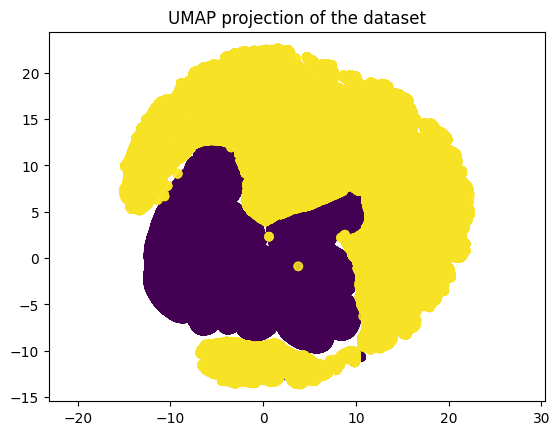

In [ ]:
!pip install umap-learn
import umap

X = joblib.load('/content/drive/MyDrive/X_adasyn.pkl')
y = joblib.load('/content/drive/MyDrive/y_adasyn.pkl')
reducer = umap.UMAP(n_neighbors=20)

# Fit the model to your data and transform it
embedding = reducer.fit_transform(X)

# Plotting the result if reduced to 2 dimensions
plt.scatter(embedding[:, 0], embedding[:, 1], c=y,alpha=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=12)
plt.show()

In [ ]:
!pip install umap-learn


In [ ]:
lesionls = []
hcls = []
tr_split = 0.8
# files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/MRFupload_to_hpc/MRFupload_to_hpc/*")))
files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/NewMRF/*")))
ind = np.arange(len(files))
files = files[ind]
id_split = int(floor(len(files)*tr_split))
trainDS = files[0:id_split]
testDS = files[id_split:]
for idx in range(0,len(testDS)):
  n1_img = nib.load(testDS[idx])
  n1 = n1_img.get_fdata()
  n1[:,:,:,-5] = (n1[:,:,:,-5]>=3)&(n1[:,:,:,-5]<=8)*1
  n1[:,:,:,-4] = (n1[:,:,:,-4]>=3)&(n1[:,:,:,-4]<=8)*1
  n1[:,:,:,-3] = (n1[:,:,:,-3]>=3)&(n1[:,:,:,-3]<=8)*1
  n1[:,:,:,-2] = (n1[:,:,:,-2]>=3)&(n1[:,:,:,-2]<=8)*1
  n1[:,:,:,-1] = n1[:,:,:,-1]*(np.sum(n1[:,:,:,-5:-1], axis = -1) > 0)

  image = np.array(n1[12:172,14:206,12:172, :])
  mask = np.array(n1[12:172,14:206,12:172,-1:]).squeeze()
  lesionls.append(image[(image[:,:,:,0]>=0),:])
hc_stack = np.vstack(lesionls)
hc_stack = hc_stack[(hc_stack[:, 0] > 0)]
hc_stack = hc_stack[hc_stack[:, 5] < 0.2]

Xy = hc_stack
X_te = np.hstack([Xy[:, 1:6], Xy[:, -5:-1]])
y_te = Xy[:,-1]
X_te[:, 0] = X_te[:, 0] / 3000
X_te[:, 1] = X_te[:, 1] / 2000
X_te = np.nan_to_num(X_te)

In [ ]:
import umap

X = joblib.load('/content/drive/MyDrive/X_adasyn.pkl')
y = joblib.load('/content/drive/MyDrive/y_adasyn.pkl')
reducer = umap.UMAP(n_neighbors=20)

# Fit the model to your data and transform it
embedding = reducer.fit_transform(X)

mapper = umap.UMAP(n_neighbors=20, n_components=2).fit(X, y)
train_embedding = mapper.transform(X)

lesionls = []
hcls = []
tr_split = 0.8
# files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/MRFupload_to_hpc/MRFupload_to_hpc/*")))
files = np.array(sorted(glob.glob(r"/content/drive/MyDrive/NewMRF/*")))
ind = np.arange(len(files))
files = files[ind]
id_split = int(floor(len(files)*tr_split))
trainDS = files[0:id_split]
testDS = files[id_split:]
for idx in range(0,len(testDS)):
  n1_img = nib.load(testDS[idx])
  n1 = n1_img.get_fdata()
  n1[:,:,:,-5] = (n1[:,:,:,-5]>=3)&(n1[:,:,:,-5]<=8)*1
  n1[:,:,:,-4] = (n1[:,:,:,-4]>=3)&(n1[:,:,:,-4]<=8)*1
  n1[:,:,:,-3] = (n1[:,:,:,-3]>=3)&(n1[:,:,:,-3]<=8)*1
  n1[:,:,:,-2] = (n1[:,:,:,-2]>=3)&(n1[:,:,:,-2]<=8)*1
  n1[:,:,:,-1] = n1[:,:,:,-1]*(np.sum(n1[:,:,:,-5:-1], axis = -1) > 0)

  image = np.array(n1[12:172,14:206,12:172, :])
  mask = np.array(n1[12:172,14:206,12:172,-1:]).squeeze()
  lesionls.append(image[(image[:,:,:,0]>=0),:])
hc_stack = np.vstack(lesionls)
hc_stack = hc_stack[(hc_stack[:, 0] > 0)]
hc_stack = hc_stack[hc_stack[:, 5] < 0.2]

Xy = hc_stack
X_te = np.hstack([Xy[:, 1:6], Xy[:, -5:-1]])
y_te = Xy[:,-1]
X_te[:, 0] = X_te[:, 0] / 3000
X_te[:, 1] = X_te[:, 1] / 2000
X_te = np.nan_to_num(X_te)

test_embedding = mapper.transform(X_te)

# Plotting the result if reduced to 2 dimensions
plt.scatter(train_embedding[:, 0], train_embedding[:, 1], c=y, alpha=0.2)
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_te, alpha=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=12)
plt.savefig('/content/drive/MyDrive/2dproj.png')
plt.show()